In [ ]:
import os
import random
from abc import abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as F1
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, transforms
from tqdm import tqdm
from types_ import *
from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim_skimage

In [ ]:
class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size: int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [ ]:
class PairedTopoDataset(Dataset):
    def __init__(self, image_dir, topo_dir, transform):
        """
        Args:
            image_dir (str): Папка с обычными изображениями (без `_topo`).
            topo_dir (str): Папка с топо-изображениями (с `_topo`).
            transform (callable, optional): Дополнительные аугментации.
        """
        self.image_dir = image_dir
        self.topo_dir = topo_dir
        self.transform = transform
        self.to_tensor = ToTensor()  # Конвертирует PIL → Tensor и нормализует в [0, 1]

        # Собираем все файлы и находим пары (image, topo)
        self.pairs = self._find_paired_files()

    def _extract_base(self, filename):
        """Извлекает базовое имя и номер из названия файла.
        Пример:
            "cor_000_Pomona_..._0.png" → ("cor_000_Pomona_...", 0)
            "cor_000_Pomona_..._topo_5.png" → ("cor_000_Pomona_...", 5)
        """
        # Удаляем расширение (.png, .jpg и т.д.)
        base_part = os.path.splitext(filename)[0]

        # Если в названии есть `_topo`, убираем его из базовой части
        if "_topo" in base_part:
            base_part = base_part.replace("_topo", "")

        return base_part

    def _find_paired_files(self):
        """Находит все пары (image, topo) с одинаковыми base_name и номером."""
        # Собираем все файлы из image_dir и topo_dir
        image_files = os.listdir(self.image_dir)
        topo_files = os.listdir(self.topo_dir)

        # Создаем словарь: { (base_name, number) → {"image": path, "topo": path} }
        pairs_dict = {}

        # Обрабатываем обычные изображения (без `_topo`)
        for img_file in image_files:
            base = self._extract_base(img_file)
            if base is None:
                continue  # Пропускаем файлы с неправильным форматом
            key = base
            if key not in pairs_dict:
                pairs_dict[key] = {"image": None, "topo": None}
            pairs_dict[key]["image"] = os.path.join(self.image_dir, img_file)

        # Обрабатываем топо-изображения (с `_topo`)
        for topo_file in topo_files:
            base = self._extract_base(topo_file)
            if base is None:
                continue
            key = base
            if key not in pairs_dict:
                continue  # Нет пары в image_dir → пропускаем
            pairs_dict[key]["topo"] = os.path.join(self.topo_dir, topo_file)

        # Оставляем только полные пары (где есть и image, и topo)
        valid_pairs = []
        for key in pairs_dict:
            if pairs_dict[key]["image"] and pairs_dict[key]["topo"]:
                img_name = os.path.basename(pairs_dict[key]["image"])
                topo_name = os.path.basename(pairs_dict[key]["topo"])
                valid_pairs.append(
                    (
                        pairs_dict[key]["image"],  # путь к обычному изображению
                        pairs_dict[key]["topo"],  # путь к топо-изображению
                        img_name,  # имя файла обычного изображения
                        topo_name,  # имя файла топо-изображения
                    )
                )
        return valid_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, topo_path, img_name, topo_name = self.pairs[idx]
    
    # Загружаем изображения
        img = Image.open(img_path).convert("L")
        topo = Image.open(topo_path).convert("L")

        # Уменьшаем разрешение в 50 раз
        new_size = (
            int(img.width / 50),
            int(img.height / 50),
        )
        img = img.resize(new_size, Image.Resampling.LANCZOS)
        topo = topo.resize(new_size, Image.Resampling.LANCZOS)

        # Конвертируем в numpy и нормализуем
        img = np.array(img).astype(np.float32) / 255
        topo = np.array(topo).astype(np.float32) / 255

        # Преобразуем в тензоры [1, H, W]
        img_tensor = self.to_tensor(img)
        topo_tensor = self.to_tensor(topo)
        
        # Применяем аугментации
        img_tensor = self.transform(img_tensor)
        topo_tensor = self.transform(topo_tensor)

#         # Объединяем по каналам → [2, H, W]
#         combined = torch.cat((img_tensor, topo_tensor), dim=0)

#         # Применяем аугментации
#         if self.transform:
#             combined = self.transform(combined)

        return topo_tensor, topo_name

In [ ]:
class PairedTopoDataset(Dataset):
    def __init__(self, image_dir, topo_dir, transform):
        """
        Args:
            image_dir (str): Папка с обычными изображениями (без `_topo`).
            topo_dir (str): Папка с топо-изображениями (с `_topo`).
            transform (callable, optional): Дополнительные аугментации.
        """
        self.image_dir = image_dir
        self.topo_dir = topo_dir
        self.transform = transform
        self.to_tensor = ToTensor()
        self.pairs = self._find_paired_files()

    def _extract_base_name(self, filename):
        """Извлекает базовое имя из названия файла (без _topo и расширения)"""
        name = os.path.splitext(filename)[0]
        return name.replace("_topo", "")

    def _find_paired_files(self):
        """Находит пары (image, topo) с одинаковыми базовыми именами"""
        image_files = {self._extract_base_name(f): f for f in os.listdir(self.image_dir)}
        topo_files = {self._extract_base_name(f): f for f in os.listdir(self.topo_dir)}
        
        # Находим общие базовые имена
        common_bases = set(image_files.keys()) & set(topo_files.keys())
        
        # Создаем пары
        valid_pairs = []
        for base in common_bases:
            img_path = os.path.join(self.image_dir, image_files[base])
            topo_path = os.path.join(self.topo_dir, topo_files[base])
            valid_pairs.append((
                img_path,
                topo_path,
                image_files[base],  # имя обычного файла
                topo_files[base]    # имя топо-файла
            ))
        
        return valid_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, topo_path, img_name, topo_name = self.pairs[idx]
        
        # Загружаем изображения
        img = Image.open(img_path).convert("L")
        topo = Image.open(topo_path).convert("L")

        # Уменьшаем разрешение в 50 раз
        new_size = (int(img.width / 50), int(img.height / 50))
        img = img.resize(new_size, Image.Resampling.LANCZOS)
        topo = topo.resize(new_size, Image.Resampling.LANCZOS)

        # Конвертируем в numpy и нормализуем
        img = np.array(img).astype(np.float32) / 255
        topo = np.array(topo).astype(np.float32) / 255

        # Преобразуем в тензоры [1, H, W]
        img_tensor = self.to_tensor(img)
        topo_tensor = self.to_tensor(topo)
        
        # Применяем аугментации
        if self.transform:
            img_tensor = self.transform(img_tensor)
            topo_tensor = self.transform(topo_tensor)

        return topo_tensor, topo_name

In [ ]:
class VanillaVAE(BaseVAE):

    def __init__(
        self, in_channels: int, latent_dim: int, hidden_dims: List = None, **kwargs
    ) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [16, 32, 64]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim
            # in_channels = 2

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 2 * 2, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 2 * 2, latent_dim)

        # Build Decoder
        modules = []
               
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 2 * 2)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1 if i < len(hidden_dims)-2 else 0
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=0,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=3, padding=1),
            nn.Upsample(size=(10, 10), mode='bilinear')  # Добавляем финальный resize до 10×10
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        # print(f"Encoder output shape: {result.shape}")
        result = torch.flatten(result, start_dim=1)
        # print(f"Flattened shape: {result.shape}")

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 64, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        def mssim_loss(recons, target):
            return 1 - ms_ssim(recons, target, data_range=1.0, size_average=True)

        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        log_var = torch.clamp(log_var, min=-10, max=10)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )
        kld_weight = 0.0001

        recons_loss = F.mse_loss(recons, input[:,0,:,:].unsqueeze(1))
        recons_weight = 0.99

        loss = recons_loss * recons_weight + kld_loss * kld_weight
        
        return {"loss": loss, "Reconstruction_Loss": recons_loss, "KLD": kld_loss}

    def sample(self, num_samples: int, current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [ ]:
image_dir=r"/home/jupyter/datasphere/filestore/fulltiles/images"  # папка с обычными изображениями
topo_dir=r"/home/jupyter/datasphere/filestore/fulltiles/topo"  # папка с топо-изображениями
    
dataset = PairedTopoDataset(
    image_dir,
    topo_dir,
    transform = None
)

In [ ]:
# Выбираем первое изображение из датасета
sample, img_name = dataset[0]  # Или sample = dataset[0][0] если возвращается (img, name)

# Размерность изображения
print(f"Размерность изображения: {sample.shape}")
print(f"Тип данных: {sample.dtype}")
print(f"Имя файла: {img_name}")

Размерность изображения: torch.Size([1, 76, 81])
Тип данных: torch.float32
Имя файла: cor_087_Minona_145x145km_23.5_-141.5_210.0km_topo.tif


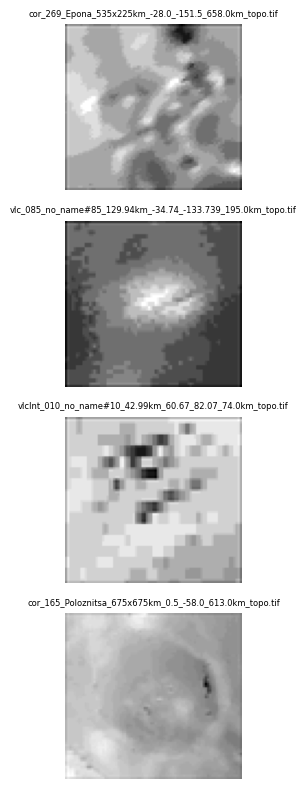

In [ ]:
batch_size = 8
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, num_workers=8
)

batch, img_names = next(iter(dataloader))

plt.figure(figsize=(12, 8))
for i in range(4):
    # Берем i-й пример из батча
    img_pair = batch[i]

    # Разделяем каналы
    img = img_pair[0].numpy().squeeze()
    # print(img.shape)

    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{img_names[i]}", fontsize=6)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaVAE(in_channels=1, latent_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 32

In [ ]:
# Загрузка весов
weights_path = '/home/jupyter/datasphere/project/vanilla_vae_topo_weights50.pth'
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [ ]:
model.eval()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=256, out_features=16, bias=True)
  (fc_var): Linear(in_features=256, out_features=16, bias=True)
  (decoder_input): Linear(in_features=16, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Sequential(
     

Error calculating metrics for vlcInt_037_no_name#37_29.653km_-68.86_90.1_91.0km_topo.tif: Image size should be larger than 160 due to the 4 downsamplings in ms-ssim
Error calculating metrics for vlc_010_Sekmet Mons_399.14km_44.382_-119.409_483.0km_topo.tif: Image size should be larger than 160 due to the 4 downsamplings in ms-ssim
Error calculating metrics for cor_358_Su-Anasy_525x225km_-78.039_39.0_367.0km_topo.tif: Image size should be larger than 160 due to the 4 downsamplings in ms-ssim
Error calculating metrics for vlc_032_no_name#32_92.82km_22.052_-15.357_192.0km_topo.tif: Image size should be larger than 160 due to the 4 downsamplings in ms-ssim


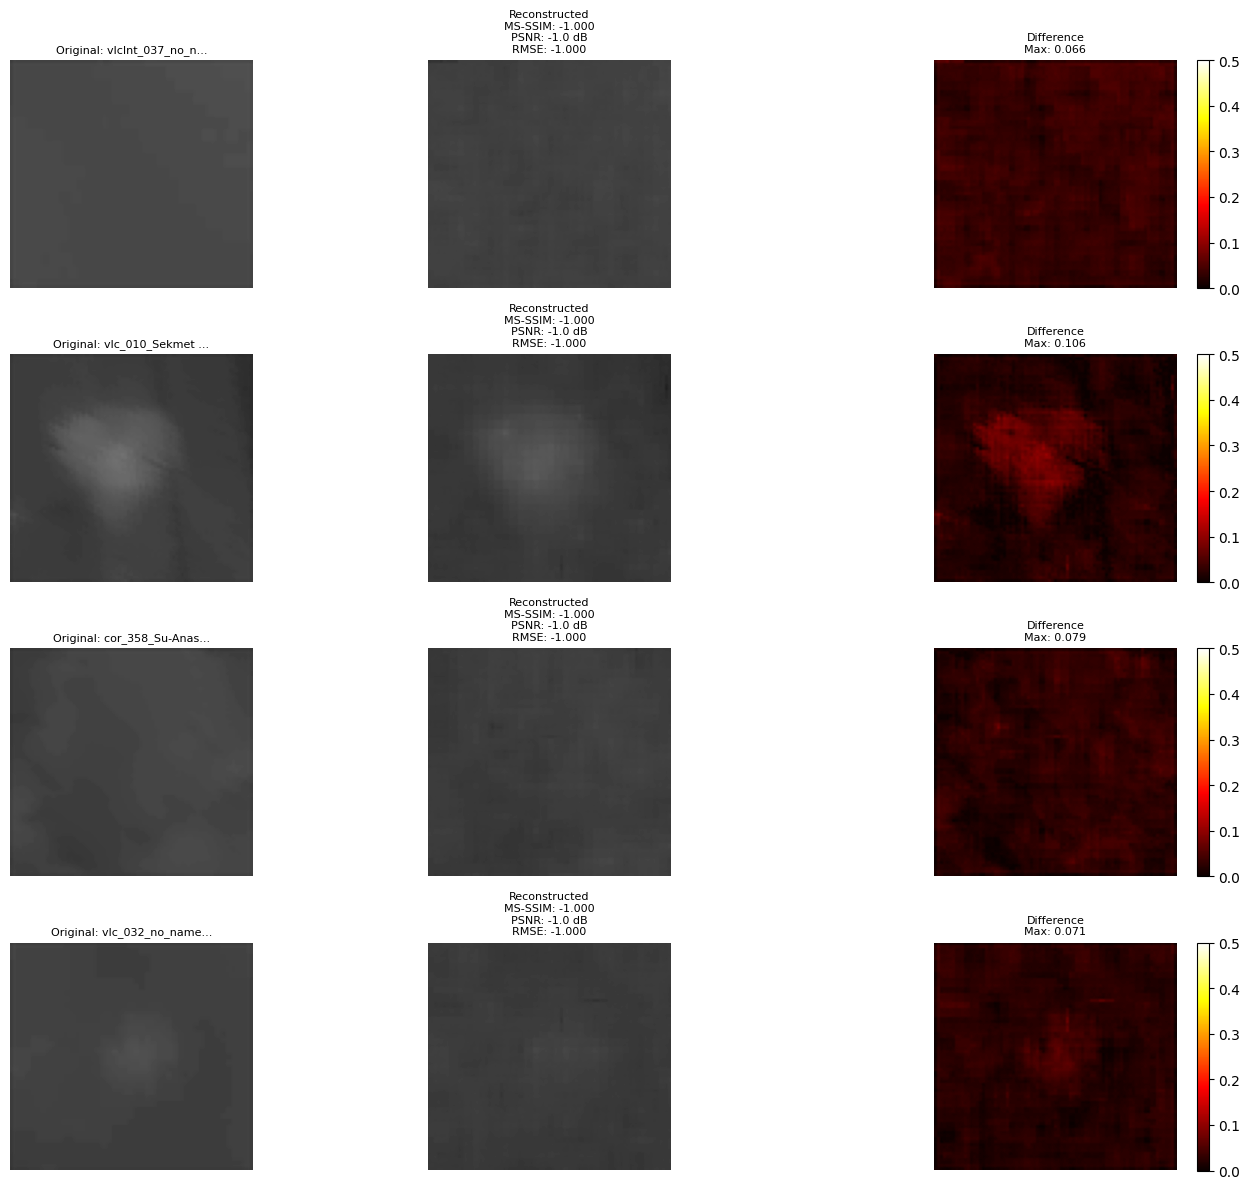


Средние метрики по 4 изображениям:
MS-SSIM: -1.0000
PSNR: -1.00
RMSE: -1.0000
Max difference: 0.0805


In [ ]:
def calculate_rmse(img1, img2):
    return np.sqrt(np.mean((img1 - img2) ** 2))


def process_large_image_with_overlap(model, large_img, tile_size=10, overlap=5, device='cuda'):
    """
    Обрабатывает большое изображение тайлами с перекрытием
    tile_size: размер тайла (квадратный)
    overlap: величина перекрытия между тайлами (рекомендуется tile_size//2)
    """
    # Проверяем размерности
    if len(large_img.shape) == 2:
        large_img = large_img.unsqueeze(0).unsqueeze(0)
    elif len(large_img.shape) == 3:
        large_img = large_img.unsqueeze(0)
    
    h, w = large_img.shape[-2:]
    stride = tile_size - overlap
    
    # Добавляем паддинг чтобы покрыть все изображение
    pad_h = (tile_size - h % stride) if h % stride != 0 else 0
    pad_w = (tile_size - w % stride) if w % stride != 0 else 0
    
    if pad_h > 0 or pad_w > 0:
        large_img = F.pad(large_img, (0, pad_w, 0, pad_h), mode='reflect')
    
    # Создаем маску для взвешенного сложения
    mask = torch.ones((1, 1, tile_size, tile_size), device=device)
    mask = F.pad(mask, (overlap//2, overlap//2, overlap//2, overlap//2), value=1e-6)
    mask = mask[:, :, :tile_size, :tile_size]
    
    # Инициализируем результат и счетчик перекрытий
    result = torch.zeros_like(large_img, device=device)
    count = torch.zeros_like(large_img, device=device)
    
    # Собираем координаты тайлов
    coords = []
    for y in range(0, h + pad_h - tile_size + 1, stride):
        for x in range(0, w + pad_w - tile_size + 1, stride):
            coords.append((y, x))
    
    # Обрабатываем тайлы
    for i in range(0, len(coords), 32):  # Пакетами по 32 тайла
        batch_coords = coords[i:i+32]
        tiles = []
        for y, x in batch_coords:
            tile = large_img[..., y:y+tile_size, x:x+tile_size]
            tiles.append(tile)
        
        tiles = torch.cat(tiles, dim=0).to(device)
        
        with torch.no_grad():
            recon_tiles = model(tiles)[0]
        
        # Добавляем обработанные тайлы в результат с учетом маски
        for j, (y, x) in enumerate(batch_coords):
            result[..., y:y+tile_size, x:x+tile_size] += recon_tiles[j] * mask
            count[..., y:y+tile_size, x:x+tile_size] += mask
    
    # Нормализуем результат
    result = result / count
    
    # Убираем паддинг если добавляли
    if pad_h > 0 or pad_w > 0:
        result = result[..., :h, :w]
    
    return result.squeeze().cpu()


with torch.no_grad():
    num_images = 4
    plt.figure(figsize=(14, 3 * num_images))
    
    ssim_values = []
    psnr_values = []
    rmse_values = []
    max_diff_values = []
    
    random_indices = random.sample(range(len(dataset)), num_images)
    
    for i in range(num_images):
        idx = random_indices[i]
        x, img_name = dataset[idx]
        x = x.unsqueeze(0)  # [1, 1, H, W]
        
        # Обрабатываем большое изображение тайлами
        reconstructed = process_large_image_with_overlap(model, x, tile_size=10, device=device)
        
        original = x[0].cpu().numpy().squeeze()
        reconstructed = reconstructed.cpu().numpy().squeeze()
        
        # Вычисляем метрики
        try:
            ssim_val = ssim_skimage(original, reconstructed, data_range=1.0)
            psnr_val = psnr(original, reconstructed, data_range=1.0)
            rmse_val = calculate_rmse(original, reconstructed)
        except Exception as e:
            print(f"Error calculating metrics for {img_name}: {str(e)}")
            ssim_val, psnr_val, rmse_val = -1, -1, -1
        
        # Сохраняем метрики
        ssim_values.append(ssim_val)
        psnr_values.append(psnr_val)
        rmse_values.append(rmse_val)
        
        # Визуализация
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(original, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Original: {img_name[:15]}...", fontsize=8)
        plt.axis('off')

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Reconstructed\nSSIM: {ssim_val:.3f}\nPSNR: {psnr_val:.1f} dB, dB\nRMSE: {rmse_val:.3f}", 
                 fontsize=8)
        plt.axis('off')
        
        plt.subplot(num_images, 3, 3*i + 3)
        difference = np.abs(original - reconstructed)
        plt.imshow(difference, cmap='hot', vmin=0, vmax=0.5)
        plt.title(f"Difference\nMax: {difference.max():.3f}", fontsize=8)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        max_diff_values.append(difference.max())
    
    plt.tight_layout()
    plt.savefig('large_reconstructions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Вывод средних метрик
    print(f"\nСредние метрики по {num_images} изображениям:")
    print(f"SSIM: {np.mean(ssim_values):.4f} (ближе к 1 - лучше)")
    print(f"PSNR: {np.mean(psnr_values):.2f} dB (чем выше, тем лучше)")
    print(f"RMSE: {np.mean(rmse_values):.4f} (ближе к 0 - лучше)")
    print(f"Max difference: {np.mean(max_diff_values):.4f}")